#Completion Prediction
##This task aims to predict student success (course completion) based on their comments where:
*   completed=0 : the student didn't complete the course
*   completed=1 : the student completed the course


*   timestamp: time when the comment was posted
*   likes: number of likes the comment has received

*   word_count: number of words in the comment
*   char_count: number of characters in the comment
*   SA: sentiment analysis (1=positiive, 0=neutral, -1=negative)

**files included:**


*   Comments: contains students' comment
*   combinedComments: contains all comments by each student grouped by lwarner ID.
*   SeparateComments: same combinedComments, but every comment in one coloumn





**resources used in this notebook:**
*   glove: https://drive.google.com/file/d/1z39VM7qx1F39eR_N5yGNyJN5QmTmkMpU/view?usp=sharing
*   BERT: https://drive.google.com/drive/folders/1vXUmCd45O2X8rBtiTfPaRiq5eY4fPDoy?usp=sharing



##Importing Libraries & Data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#General imports:
import pandas as pd
import numpy as np, array
import re, os
import matplotlib.pyplot as plt

#keras
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer
from keras.layers.convolutional import Conv1D, Conv2D    
from keras.models import Sequential    
from keras.optimizers import Adam 
from keras.layers.recurrent import LSTM

#sklearn
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

#NLTK
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import wordnet
from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
from textblob import Word
from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
os.chdir('/gdrive/My Drive/Datasets/Kaggle/Coursera')
Comments = pd.read_csv("Comments.csv")
combinedComments = pd.read_csv("combinedComments.csv")
separateComments = pd.read_csv("separateComments.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356

In [ ]:
Comments

,learner_id,step,text,timestamp,likes,word_count,char_count,SA,completed
0,00000007c103,2.80,interesting and useful !,15/03/2015 7:07,1,4,24,1,1
1,00000007c103,2.80,I totally learned web development !!!Great Lec...,16/03/2015 5:49,0,7,52,1,1
2,00000007c103,5.11,Very clear concise and simple explanation,02/04/2015 3:15,0,6,41,1,1
3,000046e8f020,2.10,Great course. Jogesh has done wonderful job in...,14/11/2015 20:53,2,13,80,1,1
4,00006b585440,5.11,Perfect introduction course to Big Data,02/12/2015 10:36,1,6,39,1,1
...,...,...,...,...,...,...,...,...,...
87437,fff6a01d00f5,4.60,Best course! Best instructor! Instructor has c...,10/05/2016 21:31,1,27,175,1,0
87438,fff6a01d00f5,4.70,Very good courses for machine learning! I've g...,12/05/2016 19:38,1,11,56,1,0
87439,fff6a01d00f5,5.20,Me agrada hasta el momento,24/05/2016 14:34,8,5,26,1,0
87440,fff6a01d00f5,7.20,This course is great for anyone who wants to n...,01/06/2016 19:53,2,68,364,1,0


In [ ]:
Comments['SA'] = Comments.SA+1

In [ ]:
print(Comments.shape)
Comments = Comments.dropna().reset_index()
#Comments.text.dropna().reset_index()
Comments = Comments.drop_duplicates(subset=['text'])
print(Comments.shape)
Comments.info()

(87442, 9)
(77594, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 77594 entries, 0 to 87439
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       77594 non-null  int64  
 1   learner_id  77594 non-null  object 
 2   step        77594 non-null  float64
 3   text        77594 non-null  object 
 4   timestamp   77594 non-null  object 
 5   likes       77594 non-null  int64  
 6   word_count  77594 non-null  int64  
 7   char_count  77594 non-null  int64  
 8   SA          77594 non-null  int64  
 9   completed   77594 non-null  int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 6.5+ MB


In [ ]:
#taking sample to visualise comments
Comments = shuffle(Comments)
viz = Comments.head(500)

from sklearn.feature_extraction.text import TfidfVectorizer
from yellowbrick.text import TSNEVisualizer
from yellowbrick.datasets import load_hobbies
from sklearn.manifold import TSNE
import plotly.express as px
tfidf = TfidfVectorizer()

X = tfidf.fit_transform(viz.text)
features = X
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)
fig = px.scatter(
    projections, x=0, y=1,
    color=viz.completed, labels={'color': 'class'}
)
fig.show()

In [ ]:
#how many commenting student we have?
len(Comments.learner_id.unique())

8215

In [ ]:
#check size of our classess:
Comments.completed.value_counts()

0    64817
1    12777
Name: completed, dtype: int64

## Data Preprocessing

In [ ]:
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

Comments['text'] = Comments.text.apply(preprocess_text)

#replace US-English words with UK-English
#elongated and repeated words to be processed, check how.
#any liabrary to reshape contractions?

In [ ]:
#identifying the prober max length

len_data = pd.DataFrame()
len_data['text_length'] = Comments['text'].apply(lambda x: len(x.split(" ")))

print(len_data.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))

maxlen = 100 # based on the percentiles

        text_length
count  77594.000000
mean      13.502719
std       16.462133
min        1.000000
10%        2.000000
20%        4.000000
30%        5.000000
40%        7.000000
50%        9.000000
60%       11.000000
70%       14.000000
80%       20.000000
90%       30.000000
max      672.000000


In [ ]:
#Comments = Comments[['text','completed']]
X = Comments.text
y = Comments['completed']

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1
X = pad_sequences(X, padding='post', maxlen=maxlen)

In [ ]:
print(X.shape)
X

(77594, 100)


array([[  12,   19,    0, ...,    0,    0,    0],
       [ 512,   32,  256, ...,    0,    0,    0],
       [  51,  376,   90, ...,    0,    0,    0],
       ...,
       [4240, 1320,   24, ...,    0,    0,    0],
       [   1,    2,  104, ...,    0,    0,    0],
       [  57,   25,   95, ...,    0,    0,    0]], dtype=int32)

In [ ]:
#if you want to add other features:
features = []
Comments = Comments.reset_index()
for i in range(0,X.shape[0]):
  l = list(X[i])
  l.append(Comments['likes'][i])
  l.append(Comments['word_count'][i])
  l.append(Comments['char_count'][i])
  l.append(Comments['SA'][i])
  features.append(l)

In [ ]:
len(features[0])

1004

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42, stratify=y)  #stratify=y equalise the number of observations in both Train and Test sets
#X_train.shape, X_test.shape, y_train.shape, y_test.shape
len(X_train), len(X_test), len(y_train),len(y_test)

(69834, 7760, 69834, 7760)

##upsampling training set only

In [ ]:
trainig_data = pd.DataFrame(X_train)
trainig_data['completed'] = y_train
trainig_data.shape

(69834, 101)

In [ ]:
import collections as coll
from sklearn.utils import resample

# Separate majority and minority classes
majority = trainig_data[trainig_data['completed']==0]
minority = trainig_data[trainig_data.completed==1]

# upsasmpling minority class
minoroty_upsampled = resample(minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=trainig_data[trainig_data.completed == 0].shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
UpSampling = pd.concat([majority, minoroty_upsampled])
print(UpSampling.completed.value_counts())

1.0    44567
0.0    44567
Name: completed, dtype: int64


In [ ]:
#in upssampling only, shuffle the data after upssampling
from sklearn.utils import shuffle
UpSampling = shuffle(UpSampling)

In [ ]:
X_train = UpSampling.drop(['completed'], axis=1).values
y_train = UpSampling['completed'].values

X_test = X_test#.values
y_test = y_test#.values

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((89134, 100), (89134,), (7760, 100), (7760,))

#Machine learning

##Naive Bayes
References:

https://stackoverflow.com/questions/24647400/what-is-the-best-stemming-method-in-python
http://billchambers.me/tutorials/2014/12/21/tf-idf-explained-in-python.html
http://billchambers.me/tutorials/2015/01/14/python-nlp-cheatsheet-nltk-scikit-learn.html
https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf
https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a

### Term Frequency-Inverse Document Frequency (TF-IDF)
Term-frequency-inverse document frequency (TF-IDF) is another way to judge the topic of an article by the words it contains. With TF-IDF, words are given weight – TF-IDF measures relevance, not frequency. That is, wordcounts are replaced with TF-IDF scores across the whole dataset.

First, TF-IDF measures the number of times that words appear in a given document (that’s term frequency). But because words such as “and” or “the” appear frequently in all documents, those are systematically discounted. That’s the inverse-document frequency part. The more documents a word appears in, the less valuable that word is as a signal. That’s intended to leave only the frequent AND distinctive words as markers. Each word’s TF-IDF relevance is a normalized data format that also adds up to one.

![title](https://deeplearning4j.org/img/tfidf.png)

### Ngrams Example

In [ ]:
from nltk import ngrams
sentence = 'this is a foo bar sentences and i want to ngramize it'
n = 2
bigrams = ngrams(sentence.split(), n)
for grams in bigrams:
  print (grams)

('this', 'is')
('is', 'a')
('a', 'foo')
('foo', 'bar')
('bar', 'sentences')
('sentences', 'and')
('and', 'i')
('i', 'want')
('want', 'to')
('to', 'ngramize')
('ngramize', 'it')


In [ ]:
y_train = y_train.astype('int')
y_test = y_test.astype('int')

# Text to vector
tf_idf_vect = TfidfVectorizer(ngram_range=(2,2))
tf_idf_train = tf_idf_vect.fit_transform(X_train.ravel()) #(X_train.values.ravel()
# instantiating classifier
clf = MultinomialNB(alpha=6, fit_prior=False,class_prior=[1,5])#, class_prior=[0.01, 0.99])
# Model fitting
clf.fit(tf_idf_train, y_train)

MultinomialNB(alpha=6, class_prior=[1, 5], fit_prior=False)

In [ ]:
tf_idf_test = tf_idf_vect.transform(X_test.values.ravel()) #(X_test.values.ravel())

In [ ]:
train_predicted = clf.predict(tf_idf_train)
accuracy = accuracy_score(y_train, train_predicted)
print(f"Training Accuracy: {accuracy * 100}%")
test_predicted = clf.predict(tf_idf_test)
accuracy = accuracy_score(y_test, test_predicted)
print(f"Testing Accuracy: {accuracy * 100}%")

Training Accuracy: 50.0%
Testing Accuracy: 16.469072164948454%


In [ ]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, test_predicted))
print(classification_report(y_test, test_predicted))

[[   0 6482]
 [   0 1278]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6482
           1       0.16      1.00      0.28      1278

    accuracy                           0.16      7760
   macro avg       0.08      0.50      0.14      7760
weighted avg       0.03      0.16      0.05      7760



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



##training on whole data: text+likes+SA+cha....

In [ ]:
clf = MultinomialNB(alpha=6, fit_prior=False,class_prior=[1,5])#, class_prior=[0.01, 0.99])
# Model fitting
clf.fit(X_train, y_train)

MultinomialNB(alpha=6, class_prior=[1, 5], fit_prior=False)

In [ ]:
train_predicted = clf.predict(X_train)
accuracy = accuracy_score(y_train, train_predicted)
print(f"Training Accuracy: {accuracy * 100}%")
test_predicted = clf.predict(X_test)
accuracy = accuracy_score(y_test, test_predicted)
print(f"Testing Accuracy: {accuracy * 100}%")

Training Accuracy: 18.23037488902254%
Testing Accuracy: 18.324742268041234%


In [ ]:
import sklearn.metrics
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, test_predicted))
print(classification_report(y_test, test_predicted))

[[ 173 6309]
 [  29 1249]]
              precision    recall  f1-score   support

           0       0.86      0.03      0.05      6482
           1       0.17      0.98      0.28      1278

    accuracy                           0.18      7760
   macro avg       0.51      0.50      0.17      7760
weighted avg       0.74      0.18      0.09      7760



##Logistic Regression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(2,2))
#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2)) #stop_words='english', encoding='latin-1',
features = tfidf.fit_transform(Comments.text.values.ravel())
labels = Comments.completed
features.shape

(77594, 457673)

In [ ]:
l = features[0].toarray()
l[0].shape

(457673,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.10, random_state=42, stratify=labels)  #stratify=y equalise the number of observations in both Train and Test sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69834, 457673), (7760, 457673), (69834,), (7760,))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=10, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  model.fit(X_train,y_train)
  y_pred=model.predict(X_test)
  print(classification_report(y_test,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6482
           1       0.00      0.00      0.00      1278

    accuracy                           0.84      7760
   macro avg       0.42      0.50      0.46      7760
weighted avg       0.70      0.84      0.76      7760

              precision    recall  f1-score   support

           0       0.84      0.99      0.91      6482
           1       0.13      0.01      0.01      1278

    accuracy                           0.83      7760
   macro avg       0.48      0.50      0.46      7760
weighted avg       0.72      0.83      0.76      7760

              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6482
           1       0.00      0.00      0.00      1278

    accuracy                           0.83      7760
   macro avg       0.42      0.50      0.45      7760
weighted avg       0.70      0.83      0.76      7760



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6482
           1       0.00      0.00      0.00      1278

    accuracy                           0.84      7760
   macro avg       0.42      0.50      0.46      7760
weighted avg       0.70      0.84      0.76      7760



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.835299
1,RandomForestClassifier,1,0.835299
2,RandomForestClassifier,2,0.835363
3,RandomForestClassifier,3,0.835363
4,RandomForestClassifier,4,0.835352
5,LinearSVC,0,0.827695
6,LinearSVC,1,0.828855
7,LinearSVC,2,0.825504
8,LinearSVC,3,0.827308
9,LinearSVC,4,0.827877


##Random Forset

#Deepl Learning
Preparing the Embedding Layer

In [ ]:
os.chdir('/gdrive/My Drive/')
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

## Text Classification with Simple Neural Network

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen , trainable=True) #weights=[embedding_matrix]
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 100)          3714400   
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 10001     
Total params: 3,724,401
Trainable params: 3,724,401
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
2229/2229 [==============================] - 43s 19ms/step - loss: 0.6604 - acc: 0.5815 - val_loss: 0.5089 - val_acc: 0.7348
Epoch 2/15
2229/2229 [==============================] - 43s 19ms/step - loss: 0.3783 - acc: 0.8193 - val_loss: 0.4405 - val_acc: 0.7784
Epoch 3/15
2229/2229 [==============================] - 42s 19ms/step - loss: 0.2742 - acc: 0.8645 - val_loss: 0.4588 - val_acc: 0.7826
Epoch 4/15
2229/2229 [==============================] - 42s 19ms/step - loss: 0.2317 - acc: 0.8810 - val_loss: 0.4771 - val_acc: 0.7938
Epoch 5/15
2229/2229 [==============================] - 43s 19ms/step - loss: 0.2110 - acc: 0.8903 - val_loss: 0.5144 - val_acc: 0.7949
Epoch 6/15
2229/2229 [==============================] - 43s 19ms/step - loss: 0.1933 - acc: 0.8989 - val_loss: 0.5345 - val_acc: 0.8042
Epoch 7/15
2229/2229 [==============================] - 43s 19ms/step - loss: 0.1884 - acc: 0.8992 - val_loss: 0.5715 - val_acc: 0.8035
Epoch 8/15
2229/2229 [==========================

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

243/243 [==============================] - 1s 2ms/step - loss: 2.0422 - acc: 0.6180


In [ ]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 2.042156219482422
Test Accuracy: 0.6180412173271179


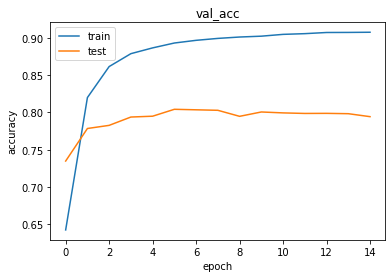

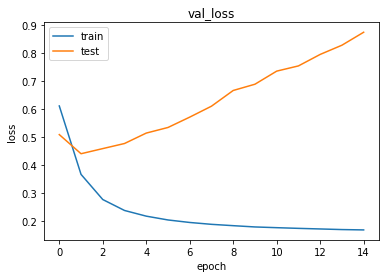

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('val_acc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('val_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict_classes(X_test, verbose=0)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn import metrics
from sklearn.metrics import confusion_matrix
report = metrics.classification_report(y_test,y_pred)
print(report)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[[4322 2160]
 [ 804  474]]
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      6482
           1       0.18      0.37      0.24      1278

    accuracy                           0.62      7760
   macro avg       0.51      0.52      0.49      7760
weighted avg       0.73      0.62      0.66      7760



In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.5188307671804766

## Text Classification with a CNN

In [ ]:
import numpy as np
np.random.seed(42)
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.models import Model
from keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

filter_sizes = [1,2,3,5]
num_filters = 32
embed_size = 100
max_features = vocab_size

def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
    #x = SpatialDropout1D(0.4)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), kernel_initializer='normal',
                                                                                    activation='relu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(1, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = get_model()


In [ ]:
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 100, 100)     3714400     input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 100, 100, 1)  0           embedding_8[0][0]                
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 100, 1, 32)   3232        reshape_2[0][0]                  
____________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train, batch_size=32, epochs=15, verbose=1, validation_split=0.2)

Epoch 1/15
2229/2229 [==============================] - 46s 20ms/step - loss: 0.6944 - accuracy: 0.5391 - val_loss: 0.6328 - val_accuracy: 0.6352
Epoch 2/15
2229/2229 [==============================] - 44s 20ms/step - loss: 0.5557 - accuracy: 0.7067 - val_loss: 0.5047 - val_accuracy: 0.7396
Epoch 3/15
2229/2229 [==============================] - 44s 20ms/step - loss: 0.3827 - accuracy: 0.8146 - val_loss: 0.4823 - val_accuracy: 0.7541
Epoch 4/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.2806 - accuracy: 0.8663 - val_loss: 0.4149 - val_accuracy: 0.8027
Epoch 5/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.2254 - accuracy: 0.8897 - val_loss: 0.3907 - val_accuracy: 0.8279
Epoch 6/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1915 - accuracy: 0.9083 - val_loss: 0.4333 - val_accuracy: 0.8257
Epoch 7/15
2229/2229 [==============================] - 44s 20ms/step - loss: 0.1717 - accuracy: 0.9166 - val_loss: 0.4506 -

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

243/243 [==============================] - 1s 3ms/step - loss: 1.7176 - accuracy: 0.7206


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 1.7176332473754883
Test Accuracy: 0.7206185460090637


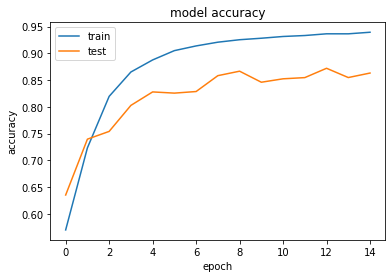

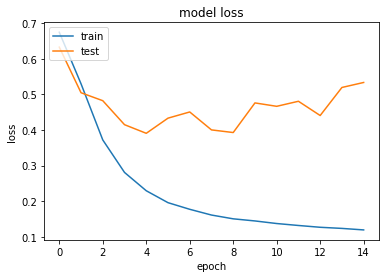

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
balanced_accuracy_score(y_test, y_pred)

0.5188307671804766

In [ ]:
y_pred[0]

array([0], dtype=int32)

In [ ]:
y_pred = model.predict(X_test, verbose=0)
y_pred = (y_pred>0.5)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn import metrics
from sklearn.metrics import confusion_matrix
report = metrics.classification_report(y_test,y_pred)
print(report)

[[5342 1140]
 [1028  250]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6482
           1       0.18      0.20      0.19      1278

    accuracy                           0.72      7760
   macro avg       0.51      0.51      0.51      7760
weighted avg       0.73      0.72      0.73      7760



## Text Classification with LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3714400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 3,831,777
Trainable params: 117,377
Non-trainable params: 3,714,400
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15, verbose=1, validation_split=validation_split)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/15
2229/2229 [==============================] - 46s 21ms/step - loss: 0.0963 - accuracy: 0.9488 - val_loss: 0.7572 - val_accuracy: 0.8550
Epoch 2/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.0962 - accuracy: 0.9494 - val_loss: 0.6958 - val_accuracy: 0.8651
Epoch 3/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.0950 - accuracy: 0.9502 - val_loss: 0.6622 - val_accuracy: 0.8726
Epoch 4/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.0953 - accuracy: 0.9497 - val_loss: 0.6793 - val_accuracy: 0.8707
Epoch 5/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.0943 - accuracy: 0.9504 - val_loss: 0.8357 - val_accuracy: 0.8495
Epoch 6/15
2229/2229 [==============================] - 44s 20ms/step - loss: 0.0936 - accuracy: 0.9498 - val_loss: 0.7484 - val_accuracy: 0.8627
Epoch 7/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.0939 - accuracy: 0.9500 - val_loss: 0.9668 -

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 2.784477949142456
Test Accuracy: 0.7274484634399414


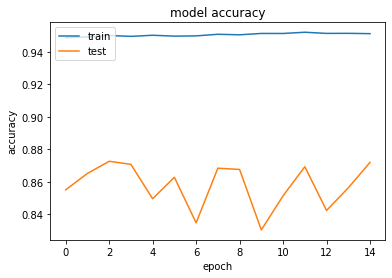

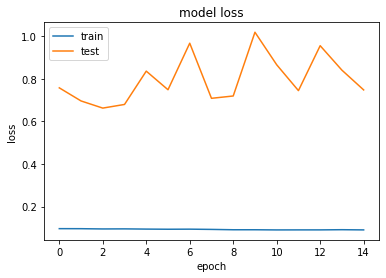

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test, verbose=0)
y_pred = y_pred>0.5
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn import metrics
from sklearn.metrics import confusion_matrix
report = metrics.classification_report(y_test,y_pred)
print(report)

[[5418 1064]
 [1051  227]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      6482
           1       0.18      0.18      0.18      1278

    accuracy                           0.73      7760
   macro avg       0.51      0.51      0.51      7760
weighted avg       0.73      0.73      0.73      7760



In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(vocab_size,100,input_length=maxlen, weights =[embedding_matrix],trainable=True)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 100)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          3714400   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=15, verbose=1, validation_split=validation_split)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1147 - accuracy: 0.9405 - val_loss: 0.4766 - val_accuracy: 0.8727
Epoch 2/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1143 - accuracy: 0.9418 - val_loss: 0.6526 - val_accuracy: 0.8365
Epoch 3/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1141 - accuracy: 0.9424 - val_loss: 0.5467 - val_accuracy: 0.8599
Epoch 4/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1096 - accuracy: 0.9441 - val_loss: 0.5265 - val_accuracy: 0.8697
Epoch 5/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1075 - accuracy: 0.9439 - val_loss: 0.4837 - val_accuracy: 0.8802
Epoch 6/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1079 - accuracy: 0.9445 - val_loss: 0.5554 - val_accuracy: 0.8662
Epoch 7/15
2229/2229 [==============================] - 45s 20ms/step - loss: 0.1076 - accuracy: 0.9447 - val_loss: 0.5565 -

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 2.3204312324523926
Test Accuracy: 0.7155928015708923


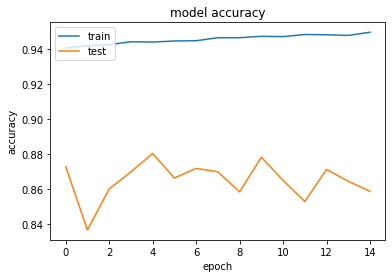

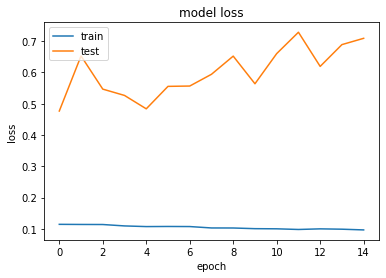

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(X_test, verbose=0)
y_pred = y_pred>0.5
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn import metrics
from sklearn.metrics import confusion_matrix
report = metrics.classification_report(y_test,y_pred)
print(report)

[[5287 1195]
 [1012  266]]
              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6482
           1       0.18      0.21      0.19      1278

    accuracy                           0.72      7760
   macro avg       0.51      0.51      0.51      7760
weighted avg       0.73      0.72      0.72      7760

